In [161]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\Berry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [212]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

%matplotlib inline

In [163]:
# Import each dataset seperately, assign to dataframes

df_customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
df_engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
df_marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
df_transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [164]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [165]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [166]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [167]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [168]:
# 'customer_id'
# 'join_date'
# 'last_purchase_date'
# 'age'
# 'gender'
# 'location'
# 'number_of_site_visits'
# 'number_of_emails_opened'
# 'number_of_clicks'
# 'campaign_id'
# 'response'
# 'promotion_type'
# 'campaign_date'
# 'transaction_id'
# 'transaction_date'
# 'transaction_amount'
# 'product_category'

In [169]:
# make transactions and marketing indexes as customer_id for easy joining
df_transactions.set_index('customer_id', inplace=True)
df_marketing.set_index('customer_id', inplace=True)

In [170]:
# Convert dates to datetime objects -- cleaning

df_marketing['campaign_date'] = pd.to_datetime(df_marketing['campaign_date'])
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])

In [171]:
# Merge Customers and Engagement on 'customer_id'
merged_df = df_customers.merge(df_engagement, on='customer_id', suffixes=('_customer', '_engagement'))

# Merge the result with Transactions on 'customer_id'
transaction_level = merged_df.merge(df_transactions, on='customer_id', suffixes=('', '_transaction'))


In [172]:
# reset index
transaction_level.reset_index(inplace=True)

In [173]:
# reset index
df_marketing.reset_index(inplace=True)

In [174]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
df_marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [175]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [176]:
# make sure sorting is correct
df_marketing[df_marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [177]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    129545 non-null  int64         
 1   customer_id              129545 non-null  int64         
 2   join_date                129545 non-null  object        
 3   last_purchase_date       129545 non-null  object        
 4   age                      116463 non-null  float64       
 5   gender                   122525 non-null  object        
 6   location                 129545 non-null  object        
 7   number_of_site_visits    129545 non-null  int64         
 8   number_of_emails_opened  129545 non-null  int64         
 9   number_of_clicks         129545 non-null  int64         
 10  transaction_id           129545 non-null  int64         
 11  transaction_date         129545 non-null  datetime64[ns]
 12  transaction_amount   

In [178]:
transaction_level.head(15)

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods
10,10,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,11,2021-09-29,1866.56,Electronics
8,8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics
12,12,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,13,2022-04-30,800.64,Home Goods
6,6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics


In [179]:
# make sure date datatype is correct
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25200 entries, 3 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.2+ MB


In [180]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=df_marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [181]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [182]:
# double check marketing aligns
df_marketing[df_marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [183]:
# double check transactions are correct
transaction_level[transaction_level['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [184]:
# delete duplicate index column

df_merged.drop(columns=['index'], inplace=True)
transaction_level.drop(columns=['index'], inplace=True)

In [185]:
# verify done correctly

transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [186]:
# verify done correctly

df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [187]:
df_merged.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [188]:
# Calculate LTV
customer_ltv = df_merged.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_ltv.rename(columns={'transaction_amount': 'LTV'}, inplace=True)

# Merge LTV back to df_merged
df_merged = df_merged.merge(customer_ltv, on='customer_id', how='left')

# Check the result
df_merged.head(15)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date,LTV
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT,3509.48
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10,3509.48
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24,3509.48
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24,3509.48
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29,3509.48
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05,3509.48
6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,11,2021-09-29,1866.56,Electronics,NaN,NaN,None,None,NaT,6081.32
7,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics,2.0,6.0,No,Free Shipping,2021-11-12,6081.32
8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,13,2022-04-30,800.64,Home Goods,2.0,6.0,No,Free Shipping,2021-11-12,6081.32
9,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics,2.0,6.0,No,Free Shipping,2021-11-12,6081.32


In [189]:
# Max = 24,298.22
# Min = 23.81
# Mean = 10108.10

df_merged['LTV'].mean()

10108.104977652552

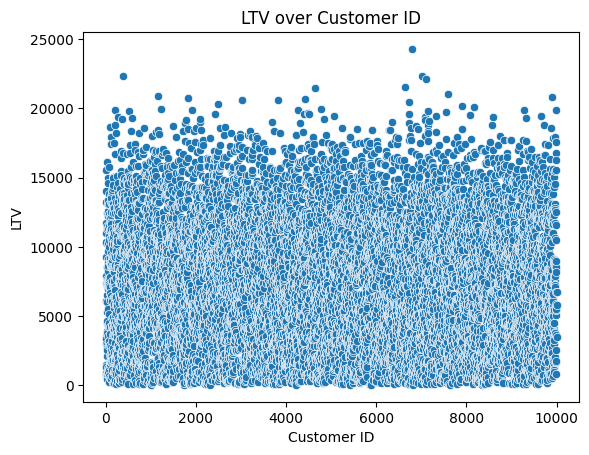

In [190]:
# Plot LTV by customer ID to see the data we're predicting
# Check for outliers that may negatively effect the models

# Ensure that the DataFrame has unique customer_id values
customer_ltv = df_merged.groupby('customer_id')['LTV'].mean().reset_index()

# Plot LTV over customer_id
sns.scatterplot(data=customer_ltv, x='customer_id', y='LTV')
plt.xlabel('Customer ID')
plt.ylabel('LTV')
plt.title('LTV over Customer ID')
plt.show()

<Axes: ylabel='LTV'>

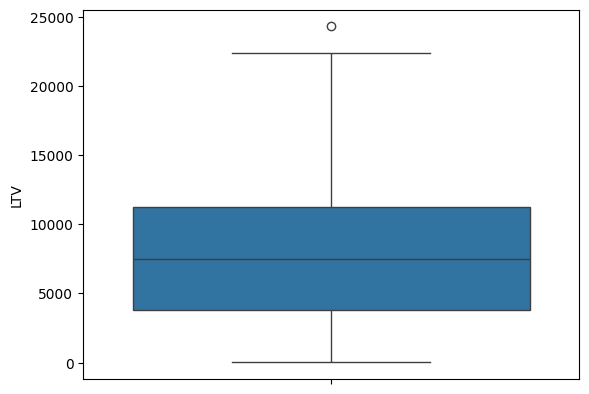

In [191]:
# Check Outliers

sns.boxplot(data=customer_ltv['LTV'])

In [192]:
# Further investigate if outlier should be removed, determined not to remove at this time, within reasonable range

customer_ltv.sort_values(by='LTV', ascending=False).head(20)

,customer_id,LTV
6794,6795,24298.22
7015,7016,22364.72
385,386,22340.06
7092,7093,22102.83
6632,6633,21518.15
4633,4634,21478.81
7583,7584,21056.06
1154,1155,20918.62
9901,9902,20845.64
1832,1833,20780.89


In [193]:
df_merged.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'campaign_customer_id',
       'campaign_campaign_id', 'campaign_response', 'campaign_promotion_type',
       'campaign_campaign_date', 'LTV'],
      dtype='object')

In [194]:
# Lets start Building Models!
# Consider what variables we want to use to predict LTV
# I want the model to be able to predict LTV after the first transaction, so lets only use first transaction information

numeric_columns = ['age','number_of_site_visits','number_of_emails_opened','number_of_clicks','transaction_amount']
categorical_columns = ['gender','location','product_category']

In [206]:
# Predicting exact LTV is unrealistic and going to be inaccurate so lets put customers into 3 categores, low, medium, high based on LTV

# Define the quantile thresholds
low_threshold = df_merged['LTV'].quantile(0.33)
high_threshold = df_merged['LTV'].quantile(0.67)

# Function to classify LTV
def classify_ltv(ltv):
    if ltv <= low_threshold:
        return 'Low'
    elif ltv <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column
df_merged['LTV_category'] = df_merged['LTV'].apply(classify_ltv)

# Display the first few rows to verify
print(df_merged[['customer_id', 'LTV', 'LTV_category']].head())

   customer_id      LTV LTV_category
0            1  3509.48          Low
1            1  3509.48          Low
2            1  3509.48          Low
3            1  3509.48          Low
4            1  3509.48          Low


In [196]:
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [200]:
# Create a copy of transaction_level to avoid modifying the original DataFrame
model_data = transaction_level.copy()

# Step 1.1: Drop rows where age is NaN
model_data = model_data.dropna(subset=['age'])

# Step 1.2: Fill NaN values for gender with "Other"
model_data['gender'] = model_data['gender'].fillna('Other')

# Step 1.3: Filter the first transaction for each customer based on transaction_date
model_data = model_data.sort_values(by=['customer_id', 'transaction_date']).drop_duplicates(subset=['customer_id'], keep='first')

# Convert join_date and last_purchase_date to datetime
model_data['join_date'] = pd.to_datetime(model_data['join_date'], errors='coerce')
model_data['last_purchase_date'] = pd.to_datetime(model_data['last_purchase_date'], errors='coerce')

# Check the result
print(model_data.head())

     customer_id  join_date last_purchase_date   age  gender  \
5              1 2023-11-20         2024-03-17  56.0  Female   
28             4 2022-01-01         2022-09-01  29.0    Male   
65             6 2022-01-01         2023-02-10  55.0  Female   
93             8 2023-02-09         2023-08-09  68.0    Male   
110            9 2022-01-24         2023-08-15  68.0  Female   

               location  number_of_site_visits  number_of_emails_opened  \
5     North Shannonbury                     10                       15   
28            Grossstad                    110                       30   
65    North Richardfort                     74                       59   
93           Marquezton                     60                       22   
110  West Franciscobury                     49                       43   

     number_of_clicks  transaction_id transaction_date  transaction_amount  \
5                   1               6       2024-01-09              174.72   
28      

In [201]:
# Step 2.1: Calculate the total transaction amount for each customer (LTV)
customer_ltv = transaction_level.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_ltv.rename(columns={'transaction_amount': 'LTV'}, inplace=True)

# Step 2.2: Merge LTV back to model_data
model_data = model_data.merge(customer_ltv, on='customer_id', how='left')

# Step 2.3: Define the quantile thresholds for LTV categories
low_threshold = model_data['LTV'].quantile(0.33)
high_threshold = model_data['LTV'].quantile(0.67)

# Step 2.4: Function to classify LTV
def classify_ltv(ltv):
    if ltv <= low_threshold:
        return 'Low'
    elif ltv <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Step 2.5: Apply the function to create a new column LTV_category
model_data['LTV_category'] = model_data['LTV'].apply(classify_ltv)

# Check the result
print(model_data.head())

   customer_id  join_date last_purchase_date   age  gender  \
0            1 2023-11-20         2024-03-17  56.0  Female   
1            4 2022-01-01         2022-09-01  29.0    Male   
2            6 2022-01-01         2023-02-10  55.0  Female   
3            8 2023-02-09         2023-08-09  68.0    Male   
4            9 2022-01-24         2023-08-15  68.0  Female   

             location  number_of_site_visits  number_of_emails_opened  \
0   North Shannonbury                     10                       15   
1           Grossstad                    110                       30   
2   North Richardfort                     74                       59   
3          Marquezton                     60                       22   
4  West Franciscobury                     49                       43   

   number_of_clicks  transaction_id transaction_date  transaction_amount  \
0                 1               6       2024-01-09              174.72   
1                17              29 

In [202]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              8991 non-null   int64         
 1   join_date                8991 non-null   datetime64[ns]
 2   last_purchase_date       8991 non-null   datetime64[ns]
 3   age                      8991 non-null   float64       
 4   gender                   8991 non-null   object        
 5   location                 8991 non-null   object        
 6   number_of_site_visits    8991 non-null   int64         
 7   number_of_emails_opened  8991 non-null   int64         
 8   number_of_clicks         8991 non-null   int64         
 9   transaction_id           8991 non-null   int64         
 10  transaction_date         8991 non-null   datetime64[ns]
 11  transaction_amount       8991 non-null   float64       
 12  product_category         8991 non-

In [207]:
# Define the feature columns and the target column
feature_columns = [
    'age', 'gender', 'location', 'number_of_site_visits',
    'number_of_emails_opened', 'number_of_clicks', 'transaction_amount', 'product_category'
]
target_column = 'LTV_category'

# Select the features and target from model_data
X = model_data[feature_columns]
y = model_data[target_column]

# Check the selected features and target
print(X.head())
print(y.head())

    age  gender            location  number_of_site_visits  \
0  56.0  Female   North Shannonbury                     10   
1  29.0    Male           Grossstad                    110   
2  55.0  Female   North Richardfort                     74   
3  68.0    Male          Marquezton                     60   
4  68.0  Female  West Franciscobury                     49   

   number_of_emails_opened  number_of_clicks  transaction_amount  \
0                       15                 1              174.72   
1                       30                17              154.63   
2                       59                 7              400.87   
3                       22                 7             1554.87   
4                       43                21               73.04   

  product_category  
0         Clothing  
1      Electronics  
2       Home Goods  
3      Electronics  
4         Clothing  
0       Low
1    Medium
2      High
3      High
4      High
Name: LTV_category, dtype: objec

In [213]:
# Define the numeric and categorical columns
numeric_columns = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 'transaction_amount']
categorical_columns = ['gender', 'location', 'product_category']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ])

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the preprocessor
print(preprocessor)

ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                 ['age', 'number_of_site_visits',
                                  'number_of_emails_opened', 'number_of_clicks',
                                  'transaction_amount']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['gender', 'location', 'product_category'])])


In [214]:
# Define the models
models = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# Perform cross-validation for each model
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5)
    
    # Print the scores and the mean accuracy
    print(f'{model_name} Scores: {scores}')
    print(f'{model_name} Mean Accuracy: {scores.mean()}')

KNN Scores: [0.32017788 0.33704116 0.32424917 0.31201335 0.33759733]
KNN Mean Accuracy: 0.32621577554209147
Naive Bayes Scores: [0.33740967 0.34482759 0.33426029 0.34427141 0.33982202]
Naive Bayes Mean Accuracy: 0.3401181969219088
Logistic Regression Scores: [0.36409116 0.36095662 0.35150167 0.35317019 0.36318131]
Logistic Regression Mean Accuracy: 0.3585801900821183
Decision Tree Scores: [0.32406893 0.3320356  0.35817575 0.34482759 0.31256952]
Decision Tree Mean Accuracy: 0.334335476203873
Random Forest Scores: [0.34963869 0.35038932 0.33036707 0.33704116 0.35317019]
Random Forest Mean Accuracy: 0.34412128601911457
SVM Scores: [0.36242357 0.34705228 0.34983315 0.33982202 0.35428254]
SVM Mean Accuracy: 0.3506827115051558


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['High' 'Low' 'Medium']
